# **Satellite course: Statistical graphics, interactive visualization and computer vision in animal science**

#### 10th Workshop on Modelling Nutrient Digestion and Utilization in Farm Animals https://www.modnut2022.com/

**Authors**:
* Gota Morota, Virginia Tech http://morotalab.org/
* Ye Bi, Virginia Tech https://yebigithub.github.io/

**Date**: Wednesday, September 21, 2022


# **Set up the Google Colab environment**

First, we will mount your Google Drive to this notebook so that your code can access your files.

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Change your working directory. Your code will be able to read and write files in your working directory. Change **/content/drive/MyDrive/Students/Ye/Projects/DairyBCS/Colab** with your working directory. 

In [71]:
import os
os.chdir('/content/drive/MyDrive/Students/Ye/Projects/DairyBCS/Colab') 
# os.chdir('/content/drive/MyDrive/Ye/Projects/DairyBCS/Colab') 

# **Load Python libraries** 

In [72]:
import sys
from PIL import Image # Python Imaging Library
import matplotlib.pyplot as plt #used to show images
from google.colab.patches import cv2_imshow
import imutils
from scipy import stats # summarize data

import os
import csv
from scipy.spatial import distance as dist
from imutils import perspective
import numpy as np
# import argparse
import cv2
import pandas as pd

Check the versions of the libraries. 

In [73]:
print('Python version:', sys.version)
print('OpenCV version:', cv2.__version__)
print('NumPy version: ', np.__version__)

Python version: 3.7.14 (default, Sep  8 2022, 00:06:44) 
[GCC 7.5.0]
OpenCV version: 4.6.0
NumPy version:  1.21.6


# **Read a cow image data**

In [133]:
img = cv2.imread("_Depth_2021.png")

# **Display the image**

There are two functions **cv2_imshow** and **plt_imshow** to display images. However, OpenCV (cv2.imread) represents RGB images in BGR order rather than RGB. Thus, we have to convert the image from BGR to RGB when using the plt_imshow function. 

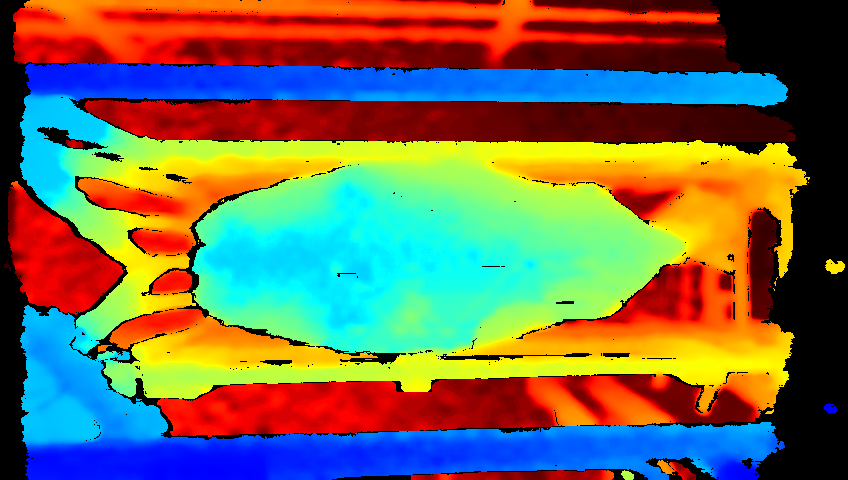

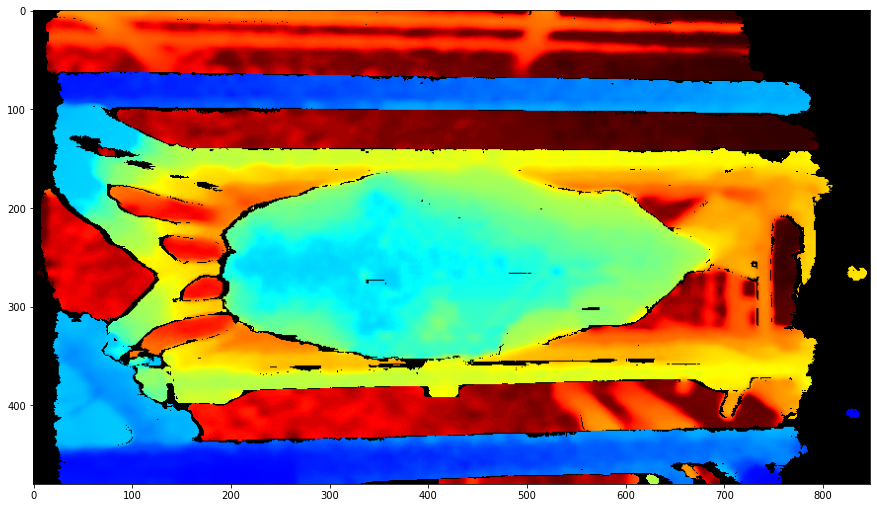

In [134]:
cv2_imshow(img)
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# **Size of the image**

In [76]:
print(f"Size of the image is {img.shape}") 

Size of the image is (480, 848, 3)


Note that in images, the coordinate is opposite. It returns (cY, cX), where c denotes a coordiante. 

The order of colors is Blue, Green, and Red (BGR). A pixel intensity ranges from 0 to 255.

In [77]:
# Pixel intensity at (50,200)
print(img[50,200,:])

# Pixel intensity at (300,400)
print(img[300,400,:])

[  0   0 105]
[206 255  48]


# **Convert to the HSV (Hue, Saturation, Value) color scale**

In general, the HSV color scale works well to separate the cow from the background. 

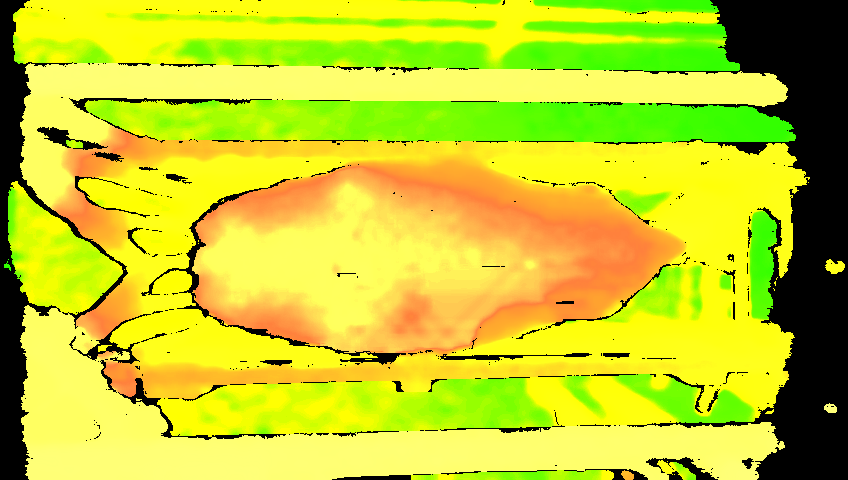

In [79]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
cv2_imshow(hsv)

The HSV color scale has three channels (hue, saturation, value). 

In [80]:
print(hsv.shape)

(480, 848, 3)


We will only exract the hue channel. 0 is Hue, 1 is Saturation, and 2 is Value.

The average of hue is 38.30


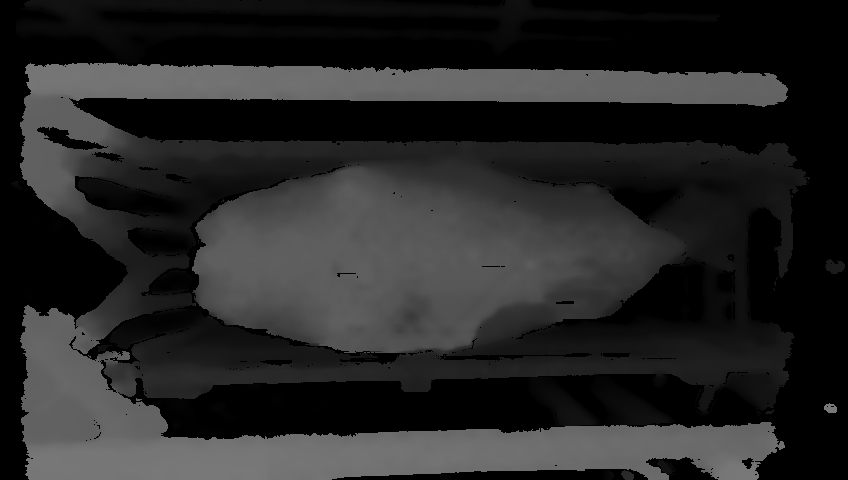

In [81]:
h = hsv[:, :, 0] 
print("The average of hue is %.2f" %np.mean(h))
cv2_imshow(h)

# **Image thresholding**

We will use the hue of 40 for the threshold. 

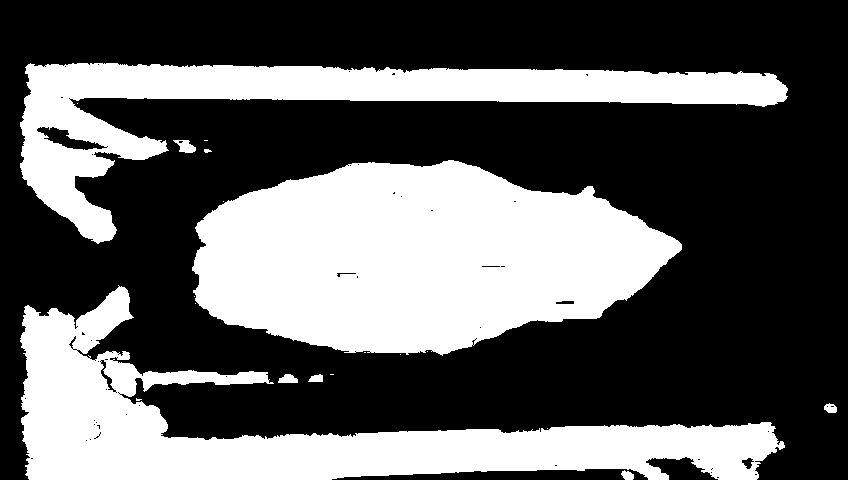

Threshold is: 40.0


In [82]:
thresh = 40
thresh, thresh_img = cv2.threshold(h, thresh, 255, cv2.THRESH_BINARY)
cv2_imshow(thresh_img)
print(f'Threshold is: {thresh}')

# **Find contours in the image**

Because the findContours function will edit (change) the original image, we use thresh_img.copy(). The variable **cnts** stores coordinates of all the shapes. The variable **c** includes the coordinates of the largest shape (area).


Note tha each individual contour returned by the findContours function is a Numpy array of (x,y) coordinates of boundary points of the object, rather than (cY, CX). 

In [83]:
# Find all countours 
cnts, _ = cv2.findContours(thresh_img.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) 
print(f"There are {len(cnts)} countorus (shapes) in total \n")

# Extract the largest area
c = max(cnts, key=cv2.contourArea) 
print("The coordinates of the contour with the largest area is: ", c, "\n")
print("The largest area is (number of pixels): ", cv2.contourArea(c)) 


There are 95 countorus (shapes) in total 

The coordinates of the contour with the largest area is:  [[[448 160]]

 [[447 161]]

 [[443 161]]

 ...

 [[458 161]]

 [[454 161]]

 [[453 160]]] 

The largest area is (number of pixels):  67862.0


# **Segment the cow and fill the holes** 

To segment the cow (the largest area) and fill the holes in the cow image, we will create a mask. A mask is a black image with the size equals to the cow image. Then we draw the contour of the cow on the masked image.  



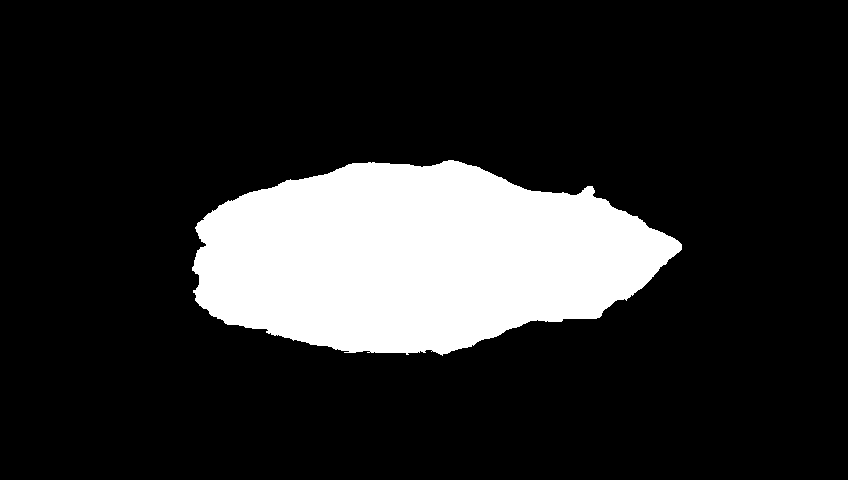

In [84]:
mask = np.zeros(thresh_img.shape, dtype = thresh_img.dtype) 

# Here, -1 fills the inside of the contour. 
fill_img = cv2.drawContours(mask, [c], 0, (255), -1) 

cv2_imshow(fill_img)

# **Draw contours**

We will convert the segmented binary image into the RGB color space so that we can draw a countour line. We can confirm whether an image with binary or RGB using the **shape** function.


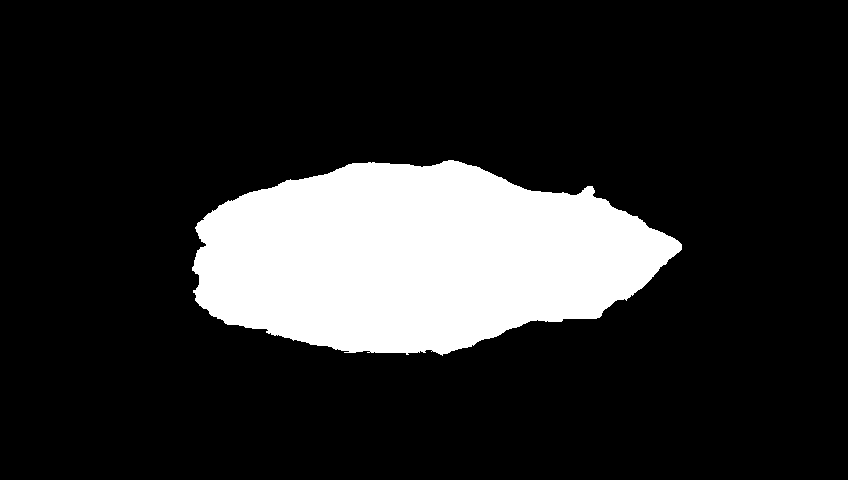

(480, 848)


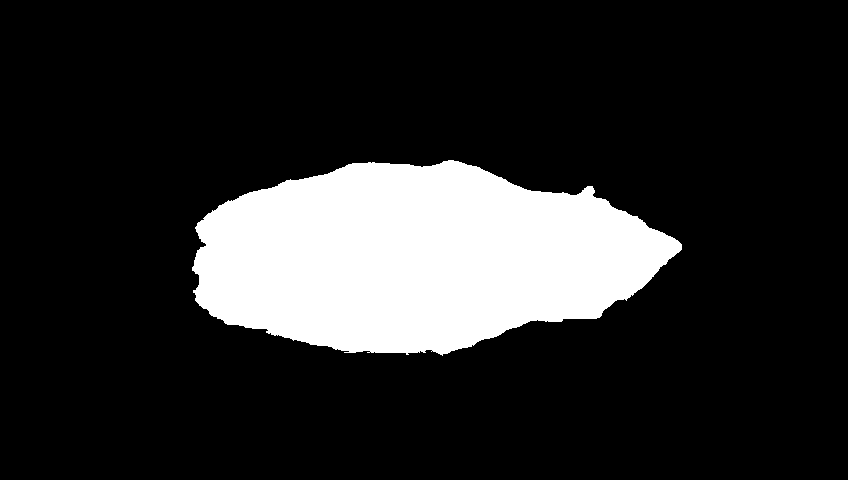

(480, 848, 3)


In [85]:
# Convert the segmented binary image into the RGB color scale
rgb_img = cv2.cvtColor(fill_img, cv2.COLOR_GRAY2RGB) 

# fill_img is a binary image
cv2_imshow(fill_img) 
print(fill_img.shape)

# rgb_img is an RGB image
cv2_imshow(rgb_img)
print(rgb_img.shape)

Then, we use the cv2.drawContours function to draw countors

* (255,0,255) uses a purple line to draw the contours. 
* 3 is the size of the line to draw the contours

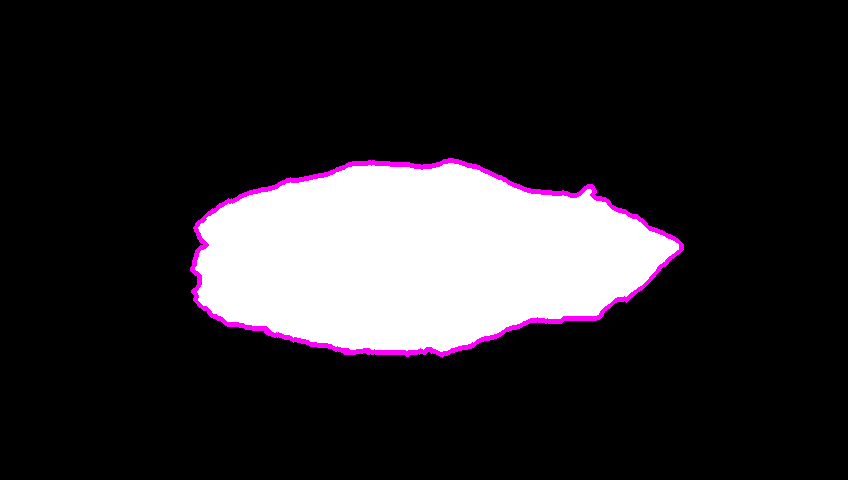

In [86]:
# Draw a countour line on the segmented image
cnts_img_bi=cv2.drawContours(rgb_img.copy(), [c], 0, (255,0,255), 3)
cv2_imshow(cnts_img_bi) 

# **Estimate length and width**


We will plot a rectangular bounding box with the smallest rotated area. 

* cv2.minAreaRect returns (center(x, y), (width, height), angle of rotation) 
* cv2.boxPoints returns the four corners of the rectangle
* np.int0 converts the bounding box floating point values to integer 
* (255, 0, 0) is blue 

The output of minAreaRect: ((436.52239990234375, 257.195068359375), (488.3116455078125, 195.23025512695312), 1.5911403894424438)
The output of boxPoints: [[189.75024 347.99307]
 [195.1712  152.83809]
 [683.29456 166.39706]
 [677.8736  361.55206]]


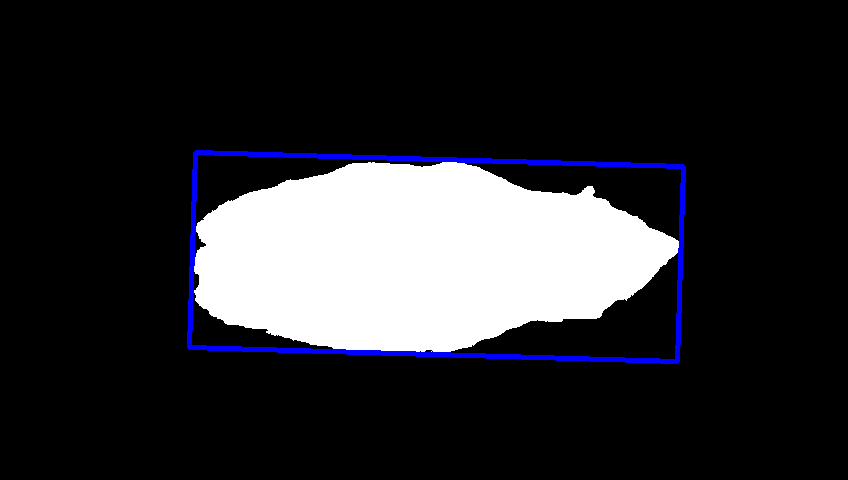

In [87]:
rect = cv2.minAreaRect(c) 
print("The output of minAreaRect:", rect)
box = cv2.boxPoints(rect)
print("The output of boxPoints:", box) # (x, y)

box = np.int0(box) 

area_img = cv2.drawContours(rgb_img.copy(), [box], 0, (255, 0, 0), 3)
cv2_imshow(area_img)

We will use the dist.euclidean to calculate length and width. 


In [88]:
(A, B, C, D) = box
dB = dist.euclidean(A, B)
dA = dist.euclidean(B, C)

print('Length is %.2f' %dA)
print('Width is %.2f' %dB)

Length is 488.20
Width is 195.09


# **Estimate height**

We will apply three methods to estimate the height of the cow. 

## 1. Centroid method

We will find the centroid of the cow. 

* https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html
* https://en.wikipedia.org/wiki/Image_moment
* https://en.wikipedia.org/wiki/Centroid

In [105]:
M = cv2.moments(c)
row_centroid = int(M["m01"] / M["m00"])
col_centroid  = int(M["m10"] / M["m00"])
print('The coordinate of the cow centroid is: ', (col_centroid , row_centroid)) # (x, y)

The coordinate of the cow centroid is:  (417, 257)


### Read a CSV depth file. 

We will visualize the CSV depth file. 

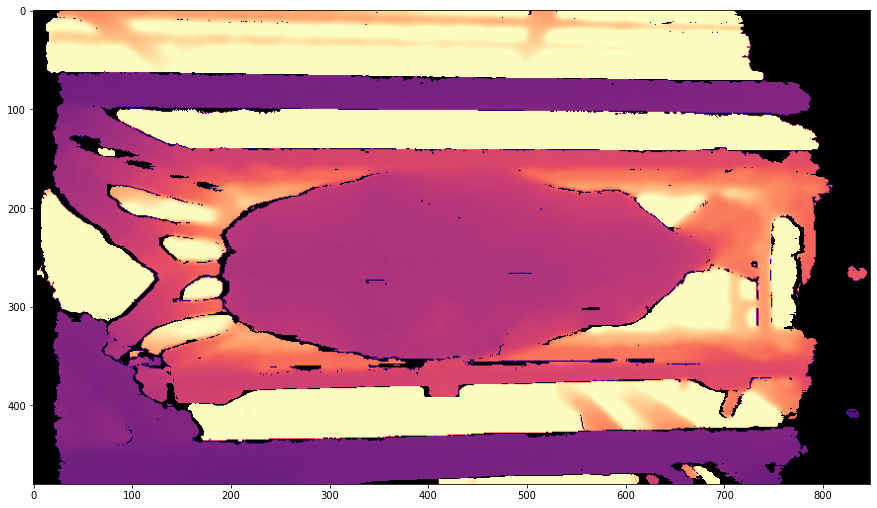

In [132]:
dfcsv = pd.read_csv("_Depth_2021.csv", header = None)

plt.figure(figsize=(15,15))
plt.imshow(dfcsv, cmap="magma", vmin=0, vmax=3)

The size of the CSV file is the same as that of the depth image.

In [94]:
print(f"The csv file size is {dfcsv.shape}")
print(f"The depth image size is {img.shape}")

The csv file size is (480, 848)
The depth image size is (480, 848, 3)


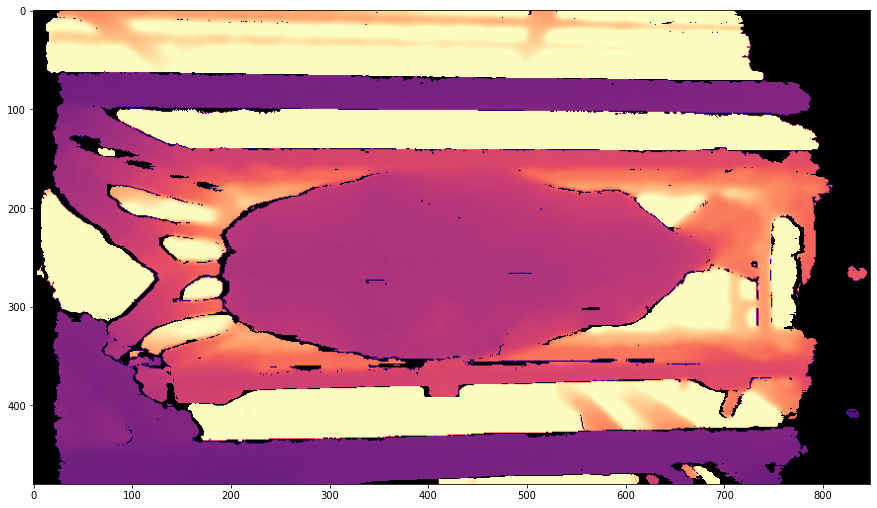

In [95]:
plt.figure(figsize=(15,15))
plt.imshow(dfcsv, cmap="magma", vmin=0, vmax=3)

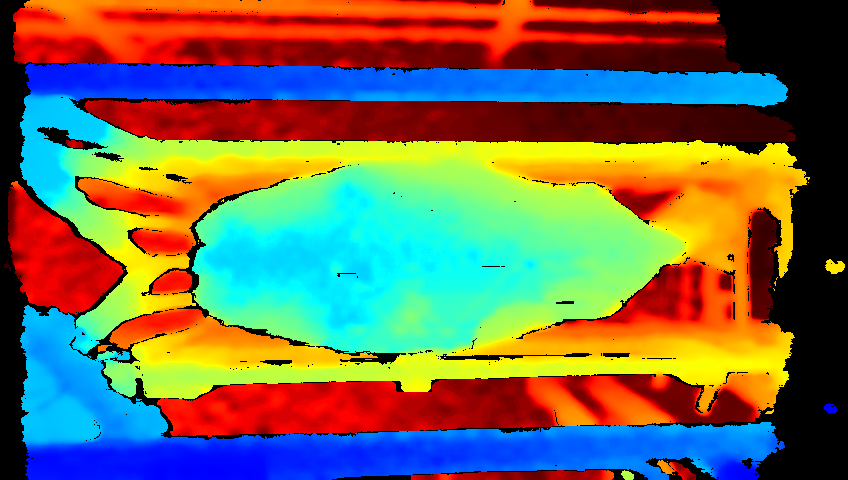

In [ ]:
cv2_imshow(img)

What is the distance of element (50,200) and (300, 400)?

In [96]:
# Pixel intensity at (50,200)
print(img[50,200,:])
# Distance at (50,200)
print(dfcsv.iloc[50,200])

# Pixel intensity at (300,400)
print(img[300,400,:])
# Distance at (300,400)
print(dfcsv.iloc[300,400])


[  0   0 105]
3.212
[206 255  48]
1.472


We will use the centroid coordinate to extract the height. The distance from the camera to the ground is 3 m. 

In [107]:
dist = dfcsv.iloc[row_centroid , col_centroid]
height = 3 - dfcsv.iloc[row_centroid , col_centroid]

print("The distance from the centroid to the camera is %.4f" %dist)
print("The height of the cow is %.4f" %height)

The distance from the centroid to the camera is 1.4500
The height of the cow is 1.5500


## 2. Average method


### Summary of the distances in the CSV file

We will summarize the distances (values) in the CSV file.

In [108]:
stats.describe(np.ravel(dfcsv)) 

DescribeResult(nobs=407040, minmax=(0.0, 8.184), mean=1.7857809158805031, variance=1.1244169900254144, skewness=-0.12629163101489713, kurtosis=-0.9130163873698227)

### Find the entire coordinates of the cow body

We will obtain the coordinates of the segmented image. The pixel object includes (y, x) information (the origin is the top left). 

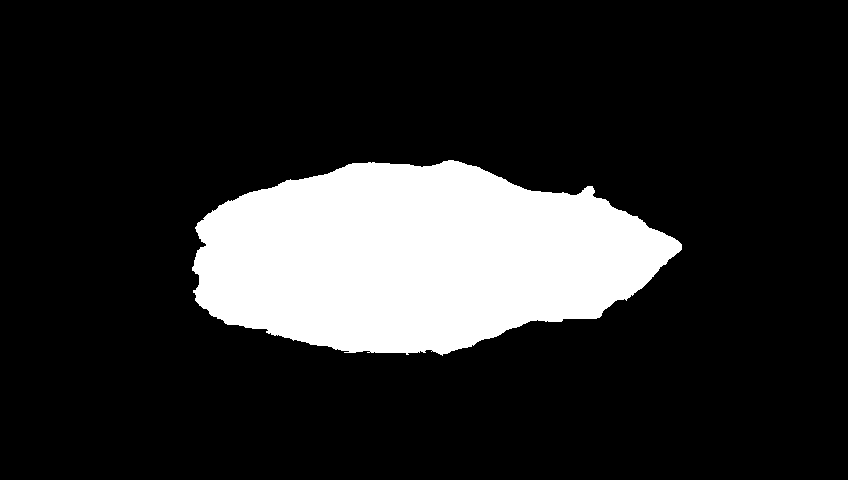

(68432, 2)


array([[160, 448],
       [160, 449],
       [160, 450],
       [160, 451]])

In [110]:
cv2_imshow(fill_img)
pixel = np.argwhere(fill_img == 255)

print(pixel.shape)
pixel[0:4,]

Create a new variable dfcsv_rows including col, row, and distance. 

In [112]:
# Initialization
dfcsv_rows = [] 
for row, col in pixel:
  dfcsv_rows.append([row, col, dfcsv.iloc[row, col]])

Convert the variable **dfcsv_rows** to a panda data frame.

In [115]:
df = pd.DataFrame(dfcsv_rows, columns = ['row', 'col', 'dist'])
print(df.shape)
print(df.head())
df.describe()

(68432, 3)
   row  col   dist
0  160  448  1.689
1  160  449  1.689
2  160  450  1.689
3  160  451  1.689
4  160  452  1.689


,row,col,dist
count,68432.000000,68432.000000,68432.000000
mean,257.430763,417.104819,1.500269
std,46.123595,119.585448,0.089272
min,160.000000,192.000000,0.000000
25%,221.000000,321.000000,1.453000
50%,257.000000,413.000000,1.482000
75%,294.000000,509.000000,1.538000
max,355.000000,681.000000,1.689000


### Draw a histogram 

(array([  120.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   102., 15182., 20859.,  9963.,  8726.,  4925.,  3772.,
         2489.,  2294.]),
 array([0.     , 0.03378, 0.06756, 0.10134, 0.13512, 0.1689 , 0.20268,
        0.23646, 0.27024, 0.30402, 0.3378 , 0.37158, 0.40536, 0.43914,
        0.47292, 0.5067 , 0.54048, 0.57426, 0.60804, 0.64182, 0.6756 ,
        0.70938, 0.74316, 0.77694, 0.81072, 0.8445 , 0.87828, 0.91206,
        0.94584, 0.97962, 1.0134 , 1.04718, 1.08096, 1.11474, 1.14852,
        1.1823 , 1.21608, 1.24986, 1.28364, 1.31742, 1.3512 , 1.38498,
        1.41876, 1.45254, 1.48632, 1.5201 , 1.55388, 1.58766, 1.62144,
        1.65522, 1.689  ]),
 <a list of 50 Pa

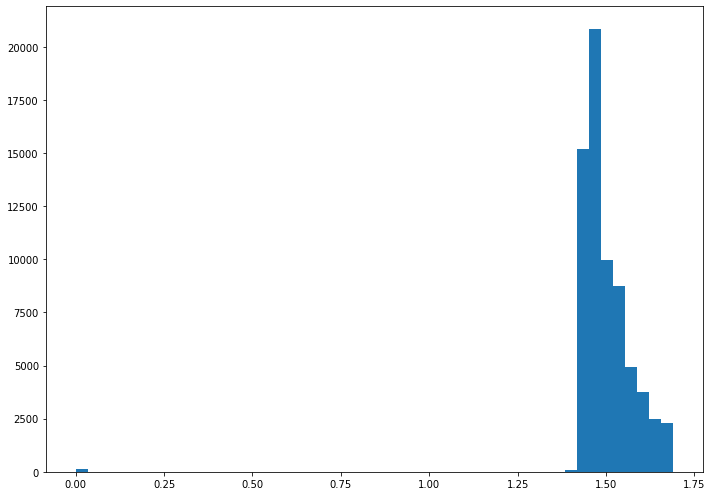

In [116]:
# Convert the panda dataframe to the numpy format
ds0 = np.array(df.dist) 
fig, axs = plt.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)

axs.hist(ds0, bins = 50)

### Remove outliers

We will replace 0 distancw with the mean of distances. 

In [117]:
df.dist.replace(to_replace=0, value = df.dist.mean(), inplace=True)
df.describe()


,row,col,dist
count,68432.000000,68432.000000,68432.000000
mean,257.430763,417.104819,1.502900
std,46.123595,119.585448,0.063368
min,160.000000,192.000000,1.409000
25%,221.000000,321.000000,1.453000
50%,257.000000,413.000000,1.482000
75%,294.000000,509.000000,1.538000
max,355.000000,681.000000,1.689000


Estimate the cow height using the average

In [118]:
dist_mean = df.dist.mean()
height = 3.0 - dist_mean

print("The average distance from the camera is: %.4f" %dist_mean)
print("The estimated height is: %.4f" %height)

The average distance from the camera is: 1.5029
The estimated height is: 1.4971


## Volume method

We will add another column named height.

In [119]:
df["height"] = 3.0 - df["dist"]
df.head()

,row,col,dist,height
0,160,448,1.689,1.311
1,160,449,1.689,1.311
2,160,450,1.689,1.311
3,160,451,1.689,1.311
4,160,452,1.689,1.311


We will calculate the projection by summing the height values covering the entire cow.  

In [120]:
volume = sum(df.height)
volume

102449.53768176425

We can visualize the volume estimated. 

In [128]:
import plotly.graph_objects as go
from scipy.interpolate import griddata
  
x = df.col
y = df.row
z = df.height

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
X,Y = np.meshgrid(xi,yi)

Z = griddata((x,y),z,(X,Y), method='linear')  #

fig = go.Figure(data=[go.Surface(x=xi, y=yi, z=Z)])
fig.update_layout(title='Volume', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene = dict(zaxis = dict(nticks=4, range=[1.2,1.7],)))

fig.show()